In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.linalg
import scipy.signal
from scipy.stats import bernoulli
from scipy.ndimage import gaussian_filter
from hmmlearn import hmm
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

In [4]:
def build_Jmatrix(N_E, N_I, p_E, p_I, W_EE, W_EI, W_IE, W_II, tau_syn):
    # rows = postsynaptic neurons, columns = presynaptic neurons
    # first N_E rows = postsynaptic excitatory neurons
    # next N_I rows = postsynaptic inhibitory neurons
    # first N_E columns = presynaptic excitatory neurons
    # next N_I columns = presynaptic inhibitory neurons
    Jmat=np.zeros(shape=(N_E+N_I, N_E+N_I))
        
    for postsyn in range(int(N_E+N_I)): # for each postsynaptic neuron, 
        # draw p_E*N_E random presynaptic excitatory neurons
        presynEs=np.random.choice(a=N_E, size=int(p_E*N_E), replace=False)
        # and p_I*N_I random presynaptic inhibitory neurons
        presynIs=np.random.choice(a=np.arange(N_E,N_I+N_E,1), size=int(p_I*N_I), replace=False) 

        # turn the previously generated column indices into W_ab, thereby allowing the 
        # output of postsynaptic neuron of type a to affect presynaptic neuron of type b's membrane potential
        if postsyn<N_E: # postynaptic neuron is inhibitory
            Jmat[postsyn,presynEs]=W_EE/(tau_syn*p_E*N_E)
            Jmat[postsyn,presynIs]=W_EI/(tau_syn*p_I*N_I)
        else: # postynaptic neuron is inhibitory
            Jmat[postsyn,presynEs]=W_IE/(tau_syn*p_E*N_E)
            Jmat[postsyn,presynIs]=W_II/(tau_syn*p_I*N_I)    
    
    return Jmat

In [5]:
def build_Jmatrix(N_E, N_I, p_E, p_I, W_EE, W_EI, W_IE, W_II, tau_syn):
    # rows = postsynaptic neurons, columns = presynaptic neurons
    # first N_E rows = postsynaptic excitatory neurons
    # next N_I rows = postsynaptic inhibitory neurons
    # first N_E columns = presynaptic excitatory neurons
    # next N_I columns = presynaptic inhibitory neurons
    Jmat=np.zeros(shape=(N_E+N_I, N_E+N_I))
        
    Jmat[:N_E,:N_E]=W_EE/(tau_syn*p_E*N_E)*np.random.binomial(n=1, p=p_E, size=(N_E,N_E)).astype(np.float32)
    Jmat[:N_E,N_E:]=W_EI/(tau_syn*p_I*N_I)*np.random.binomial(n=1, p=p_I, size=(N_E,N_I)).astype(np.float32)
    Jmat[N_E:,:N_E]=W_IE/(tau_syn*p_E*N_E)*np.random.binomial(n=1, p=p_E, size=(N_I,N_E)).astype(np.float32)
    Jmat[N_E:,N_E:]=W_II/(tau_syn*p_I*N_I)*np.random.binomial(n=1, p=p_I, size=(N_I,N_I)).astype(np.float32) 
    
    return Jmat

In [6]:
# create a spike train given the spike times and the spike counts for a given neuron
def create_spike_train(spktimes, neuron=0, dt=.01, tstop=100):
    '''create a spike train from a list of spike times and neuron indices
    spktimes: Nspikes x 2, first column is times and second is neurons
    dt and tstop should match the simulation that created spktimes'''
    spktimes_tmp = spktimes[spktimes[:, 1] == neuron][:, 0]
    spknums_tmp = spktimes[spktimes[:, 1] == neuron][:, 2]
    Nt = int(tstop/dt)
    spktrain = np.zeros((Nt,))
    spk_indices = spktimes_tmp / dt
    spk_indices = spk_indices.astype('int')
    spktrain[spk_indices] = spknums_tmp
    return spktrain

In [7]:
def spike_train_pop(spktimes,dt,tstop,N):
    pop_spk_train=np.zeros(shape=(int(tstop/dt),))
    for n in range(N):
        pop_spk_train+=create_spike_train(spktimes=spktimes, neuron=n, dt=dt, tstop=tstop)
    return pop_spk_train/N

In [45]:
# simulate the network with given parameters (all parameters/inputs to this function are constants)
def sim_network(N_E, N_I, V_rest, tau_E, tau_I, tau_noise, sigma_noise, tau_syn, h_spontaneous, h_stimulus, p_E, p_I, W_EE, W_EI, W_IE, W_II, k, alpha, delta, tstop, dt, V_0, rho):

    Nt = int(tstop/dt)

    # spike_times: a matrix whose entries contain the time at which an event (an event=1+ spikes) was generated,
    # which neuron generated the given event, and how many spikes were generated in the given event
    spike_times=[]
    # v_t: entry in row j and column i contains the membrane potential of neuron i at time step j 
    v_t = np.empty(shape=(Nt,N_E+N_I))
    #nu_t = np.empty(shape=(Nt,N_E+N_I))
    
    # n: instantaneous spike train of neurons 
    # n = np.zeros(size=[N_E+N_I]) 
    n = bernoulli.rvs(p=0, size=[N_E+N_I])
    n_t = np.zeros(shape=(Nt,N_E+N_I))
    nu_t = np.zeros(shape=(Nt,N_E+N_I))
    a_t = np.zeros(shape=(Nt,N_E+N_I))
    
    # v: instantaneous membrane potentials of neurons 
    # a: postynaptic current due to presynaptic spikes/ postynaptic filter of presynaptic spikes
    v = V_0*np.ones(N_E+N_I,)
    a = np.zeros(N_E+N_I,)
    nu = np.zeros(N_E+N_I,)
    inv_tau_mp = np.concatenate((np.ones([N_E])/tau_E,np.ones([N_I])/tau_I),axis=0)
    #Sigma_noise=np.ones(shape=(N_E+N_I,N_E+N_I))*rho*sigma_noise**2 + np.diag((1-rho)*np.ones([N_E+N_I]))
    Sigma_noise=np.ones(shape=(N_E+N_I,N_E+N_I))*rho*sigma_noise**2 + np.diag((1-rho)*np.ones([N_E+N_I]))
    sqrt_Sigma_noise=scipy.linalg.cholesky(Sigma_noise,lower=True)
    
    Jmat=build_Jmatrix(N_E, N_I, p_E, p_I, W_EE, W_EI, W_IE, W_II, tau_syn) # build random J matrix
    
    for i,t in zip(range(Nt),tqdm(range(Nt))):
        
        dW = np.random.randn(N_E+N_I) # generate N=N_E+N_I independent Wiener increments
        nu+=sqrt_Sigma_noise.dot(dW)*np.sqrt(2/tau_noise)*np.sqrt(dt)-dt*nu/tau_noise # update O-U process
        nu_t[t]=nu
        
        if t*dt<5: h=h_spontaneous # determine whether stimulus is on or off based on current time step 
        else: h=h_stimulus
        
        v += dt*(h + V_rest - v + nu)*inv_tau_mp + Jmat.dot(a) # calculate MP
        #if t==0: print('E: '+str(np.mean(v[:N_E]))+'I: '+str(np.mean(v[N_E:])))
        v_t[t]=np.ndarray.flatten(v) # update MP matrix
        
        spike_rate = k*(v-V_0)**alpha # calculate spike rate based on MP
        spike_rate[spike_rate < 0] = 0 # impose constraint that spike rate must be positive (if k<0 or alpha odd)
        spike_rate[spike_rate > 1/dt] = 1/dt
        try:
            n = bernoulli.rvs(p=spike_rate*dt) # neurons generate spikes as poisson random variables
            n_t[t] = n
        except:
            print('rates diverge') # unless the membrane potential is so high that the rates diverge
            break
            
        if t-int(delta/dt)>=0: a += dt*(n_t[t-int(delta/dt)] - a/tau_syn) # update a
        else: a += -dt*a/tau_syn
        a_t[t] = a
        
        spike_ind = np.where(n > 0)[0] # index which neurons generated spikes
            
        if len(spike_ind) > 0: # update spike_times matrix based on the spikes generated in this time step
            if len(spike_times) == 0: 
                spike_times = np.array((t*dt*np.ones(len(spike_ind),), spike_ind, n[spike_ind]))         
            else: 
                new_times = np.array((t*dt*np.ones(len(spike_ind),), spike_ind, n[spike_ind]))        
                spike_times = np.concatenate((spike_times, new_times), axis=-1)

    spike_times = np.array(spike_times).T
    if len(spike_times)>0: 
        E_spike_times = spike_times[spike_times[:, 1]<N_E] # spike_times for E cells only
        I_spike_times = spike_times[spike_times[:, 1]>=N_E] # spike_times for I cells only
        I_spike_times[:, 1] -= N_E

    else: 
        E_spike_times, I_spike_times=None, None
    
    results=[E_spike_times, I_spike_times, v_t, nu_t, a_t]
    print('sim successful')
    return results

In [30]:
def measure_PSD(lfp, dt):
    f, Pxx = scipy.signal.welch(x=np.ndarray.flatten(lfp), fs=int(1/dt), scaling='density')
    return f, Pxx

In [31]:
def measure_coherence(v_i, lfp, dt):
    f, Cxy = scipy.signal.coherence(x=np.ndarray.flatten(v_i), y=np.ndarray.flatten(lfp), fs=int(1/dt))
    #CI_jacknife95=
    return f, Cxy #, CIs

In [43]:
def generate_figure3(E_spike_times, I_spike_times, v_t, gaussian_kernel_step_width, N_E, N_I):
    E_spike_train = spike_train_pop(spktimes=E_spike_times,dt=dt,tstop=tstop,N=N_E) if len(E_spike_times) > 0 else None # average spike train for E cell population
    I_spike_train = spike_train_pop(spktimes=I_spike_times,dt=dt,tstop=tstop,N=N_I) if len(I_spike_times) > 0 else None # average spike train for I cell population
    LFP = np.mean(v_t, axis=1)
    Gaussian_smoothed_LFP=gaussian_filter(input=LFP, radius=int(gaussian_kernel_step_width/2), sigma=(gaussian_kernel_step_width/2)/4) # gaussian smoothed membrane potential of a random E cell
    Gaussian_smoothed_V_E=gaussian_filter(input=v_t[:,np.random.choice(a=np.arange(0,N_E,1), size=1, replace=False)], radius=int(gaussian_kernel_step_width/2), sigma=(gaussian_kernel_step_width/2)/4) # gaussian smoothed membrane potential of a random E cell
    Gaussian_smoothed_V_I=gaussian_filter(input=v_t[:,np.random.choice(a=np.arange(N_E,N_E+N_I,1), size=1, replace=False)], radius=int(gaussian_kernel_step_width/2), sigma=(gaussian_kernel_step_width/2)/4) # gaussian smoothed membrane potential of a random I cell
    Gaussian_smoothed_EFR=gaussian_filter(input=E_spike_train/dt, radius=int(gaussian_kernel_step_width/2),sigma=(gaussian_kernel_step_width/2)/4) if len(E_spike_times) > 0 else None # gaussian smoothed membrane potential of a random E cell
    Gaussian_smoothed_IFR=gaussian_filter(input=I_spike_train/dt, radius=int(gaussian_kernel_step_width/2),sigma=(gaussian_kernel_step_width/2)/4) if len(I_spike_times) > 0 else None # gaussian smoothed membrane potential of a random E cell
    
    ncols,nrows=2,4
    fig = plt.figure(figsize=(10, 2*nrows))
    spec = gridspec.GridSpec(nrows, ncols, figure=fig, hspace=0.5, wspace=0.5) # grid on which to put plots
    ax_Vm = fig.add_subplot(spec[3,0]) # panel A: membrane potentials of one random E cell and one random I cell over time during simulation
    ax_raster = fig.add_subplot(spec[0,0], sharex = ax_Vm) # panel A: raster plot of spikes over time during simulation
    ax_FRs = fig.add_subplot(spec[1,0], sharex = ax_Vm) # panel A: population averaged firing rates over time during simulation
    ax_LFP = fig.add_subplot(spec[2,0], sharex = ax_Vm) # panel A: LFP over time during simulation
    ax_VmLFPcoherence = fig.add_subplot(spec[2:,1]) # panel B: LFP power (normalized) vs frequency, spontaneous and evoked
    ax_LFPpower = fig.add_subplot(spec[:2,1], sharex = ax_VmLFPcoherence) # panel B: LFP power (normalized) vs frequency, spontaneous and evoked
    #time=np.linspace(0,tstop,num=len(v_t))
    
    if Gaussian_smoothed_V_E is not None: ax_Vm.plot(np.linspace(0,tstop,num=len(Gaussian_smoothed_V_E)), Gaussian_smoothed_V_E, label='E cell')
    if Gaussian_smoothed_V_I is not None: ax_Vm.plot(np.linspace(0,tstop,num=len(Gaussian_smoothed_V_I)), Gaussian_smoothed_V_I, label='I cell')
    ax_Vm.axvline(x=5,ls='--',color='black',linewidth=2,alpha=0.3)
    ax_Vm.set(ylabel=r'$V_m (mV)$',xlabel='time (s)',xticks=np.arange(0,tstop,1),xticklabels=np.arange(0,tstop,1),xlim=[0,tstop])
    ax_Vm.legend()
    E_spike_times_sample=E_spike_times[E_spike_times[:,1]<40]
    I_spike_times_sample=I_spike_times[I_spike_times[:,1]<10]
    if E_spike_times is not None: ax_raster.plot(E_spike_times_sample[:,0],10+E_spike_times_sample[:,1],'|', markersize=1, label='exc')
    if I_spike_times is not None: ax_raster.plot(I_spike_times_sample[:,0],I_spike_times_sample[:,1],'|', markersize=1, label='inh')
    ax_raster.axvline(x=5,ls='--',color='black',linewidth=2,alpha=0.3)
    ax_raster.set(ylim=[0,51],xlim=[0,tstop])
    ax_raster.legend()
    plt.setp(ax_raster.get_xticklabels(), visible=False)
    
    if Gaussian_smoothed_EFR is not None: ax_FRs.plot(np.linspace(0,tstop,num=len(Gaussian_smoothed_EFR)), Gaussian_smoothed_EFR, label='E cells')
    if Gaussian_smoothed_IFR is not None: ax_FRs.plot(np.linspace(0,tstop,num=len(Gaussian_smoothed_IFR)), Gaussian_smoothed_IFR, label='I cells')
    ax_FRs.axvline(x=5,ls='--',color='black',linewidth=2,alpha=0.3)
    plt.setp(ax_FRs.get_xticklabels(), visible=False)
    ax_FRs.legend()
    ax_FRs.set(ylabel='population rate [Hz]')
    
    if Gaussian_smoothed_LFP is not None: ax_LFP.plot(np.linspace(0,tstop,num=len(Gaussian_smoothed_LFP)), Gaussian_smoothed_LFP)
    ax_LFP.set(ylabel='LFP',xlabel=None)
    ax_LFP.axvline(x=5,ls='--',color='black',linewidth=2,alpha=0.3)
    plt.setp(ax_LFP.get_xticklabels(), visible=False)
    
    if Gaussian_smoothed_V_E is not None and Gaussian_smoothed_V_I is not None and Gaussian_smoothed_LFP is not None: 
        random_index=np.random.choice(a=[0,1])
        v_i=[Gaussian_smoothed_V_E, Gaussian_smoothed_V_I][random_index]
        print(np.shape(v_i[:int(5/dt)]))
        print(np.shape(Gaussian_smoothed_LFP[:int(5/dt)]))
        print(np.shape(v_i[int(5/dt):]))
        print(np.shape(Gaussian_smoothed_LFP[int(5/dt):]))
        f, Cxy_spontaneous=measure_coherence(v_i=v_i[:int(5/dt)], lfp=Gaussian_smoothed_LFP[:int(5/dt)], dt=dt)
        ax_VmLFPcoherence.semilogy(f, Cxy_spontaneous, label='spontaneous', color='black')
        f, Cxy_evoked=measure_coherence(v_i=v_i[int(5/dt):], lfp=Gaussian_smoothed_LFP[int(5/dt):], dt=dt)
        ax_VmLFPcoherence.semilogy(f, Cxy_evoked, label='evoked', color='C2')
        ax_VmLFPcoherence.legend()
        f, Pxx_spontaneous=measure_PSD(lfp=Gaussian_smoothed_LFP[:int(5/dt)], dt=dt)
        ax_LFPpower.semilogy(f, Pxx_spontaneous, label='spontaneous', color='black')
        f, Pxx_evoked=measure_PSD(lfp=Gaussian_smoothed_LFP[int(5/dt):], dt=dt)
        ax_LFPpower.semilogy(f, Pxx_evoked, label='evoked', color='C2')
        ax_LFPpower.legend()
        
    ax_VmLFPcoherence.set(xlabel='frequency [Hz]', ylabel=r'$V_m - LFP$'+' Coherence') #, ylim=[0.00001,1], xlim=[0.00001,100])
    ax_LFPpower.set(xlabel='frequency [Hz]', ylabel=r'LFP PSD') #, ylim=[0.00001,1], xlim=[0.00001,100])
    
    axes=[ax_raster, ax_FRs, ax_LFP, ax_Vm, ax_LFPpower, ax_VmLFPcoherence]
    
    return fig, axes

In [40]:
# define and assign values to parameters; NOTE THAT CODE IS WRITTEN IN UNITS OF seconds (s) and milivolts (mV) 
N_E=400 # number of excitatory neurons 
N_I=100 # number of excitatory neurons 
V_rest=-70 # resting membrane potential for all cells
V_0=-70 # initial (at start of simulation) membrane potential for all cells
tau_E=0.02 # membrane potential time constant for E cells, 20 ms
tau_I=0.02 # membrane potential time constant for I cells, 10 ms
tau_noise=0.05 # time constant for Ornstein-Uhlenbeck process (stochastic input to the network)
mu=0 # mean for Ornstein-Uhlenbeck process (stochastic input to the network)
sigma_noise=1 # square root of autocovariance of Ornstein-Uhlenbeck process
tau_syn=0.002 # synaptic time constant, 2 ms
h_spontaneous=2 # constant external input given to all cells prior to stimulus, 2 mV
h_stimulus=15 # constant external input given to all cells, constituting a stimulus, 15 mV
p_E=0.1 # probability that postsynaptic neuron i receives input from presynaptic E cell j
p_I=0.4 # probability that postsynaptic neuron i receives input from presynaptic I cell j
W_EE=1.25 # weight of presynaptic E cell input on MP of postsynaptic E cell
W_EI=-0.65 # weight of presynaptic E cell input on MP of postsynaptic I cell
W_IE=1.2 # weight of presynaptic I cell input on MP of postsynaptic E cell
W_II=-0.5 # weight of presynaptic I cell input on MP of postsynaptic I cell
k=0.3 # constant in equation 3; controls linear gain of the firing rate intensity function
alpha=2 # exponent in equ 3; controls nonlinearity of firing rate intensity function
delta=0.0005 # axonal time delay, 0.5 ms = 5 time steps
tstop=10 # length of time to run the simulation, 10 s
dt=0.0001 # size of time step to use in Euler-Maruyama method of SDE simulation
rho=0.2 # pairwise correlation coefficient
gaussian_kernel_time_width=0.05 # 50 ms = 500 time steps for time step dt size of 0.1 ms
gaussian_kernel_step_width=int(gaussian_kernel_time_width/dt) # 50 ms = 500 time steps for time step dt size of 0.1 ms

In [48]:
# run the simulation
tstop=10

E_spike_times, I_spike_times, v_t, nu_t, a_t = sim_network(N_E=N_E, N_I=N_I, V_rest=V_rest, tau_E=tau_E, tau_I=tau_I, tau_noise=tau_noise, tau_syn=tau_syn, 
            h_spontaneous=h_spontaneous, h_stimulus=h_stimulus, p_E=p_E, p_I=p_I, W_EE=W_EE, W_EI=W_EI, W_IE=W_IE, 
            W_II=W_II, k=k, alpha=alpha, delta=delta, tstop=tstop, dt=dt,V_0=V_0,rho=rho, sigma_noise=sigma_noise)

100%|██████████████████████████████████▉| 99999/100000 [01:40<00:00, 994.78it/s]

sim successful


(50000, 1)
(50000,)
(50000, 1)
(50000,)


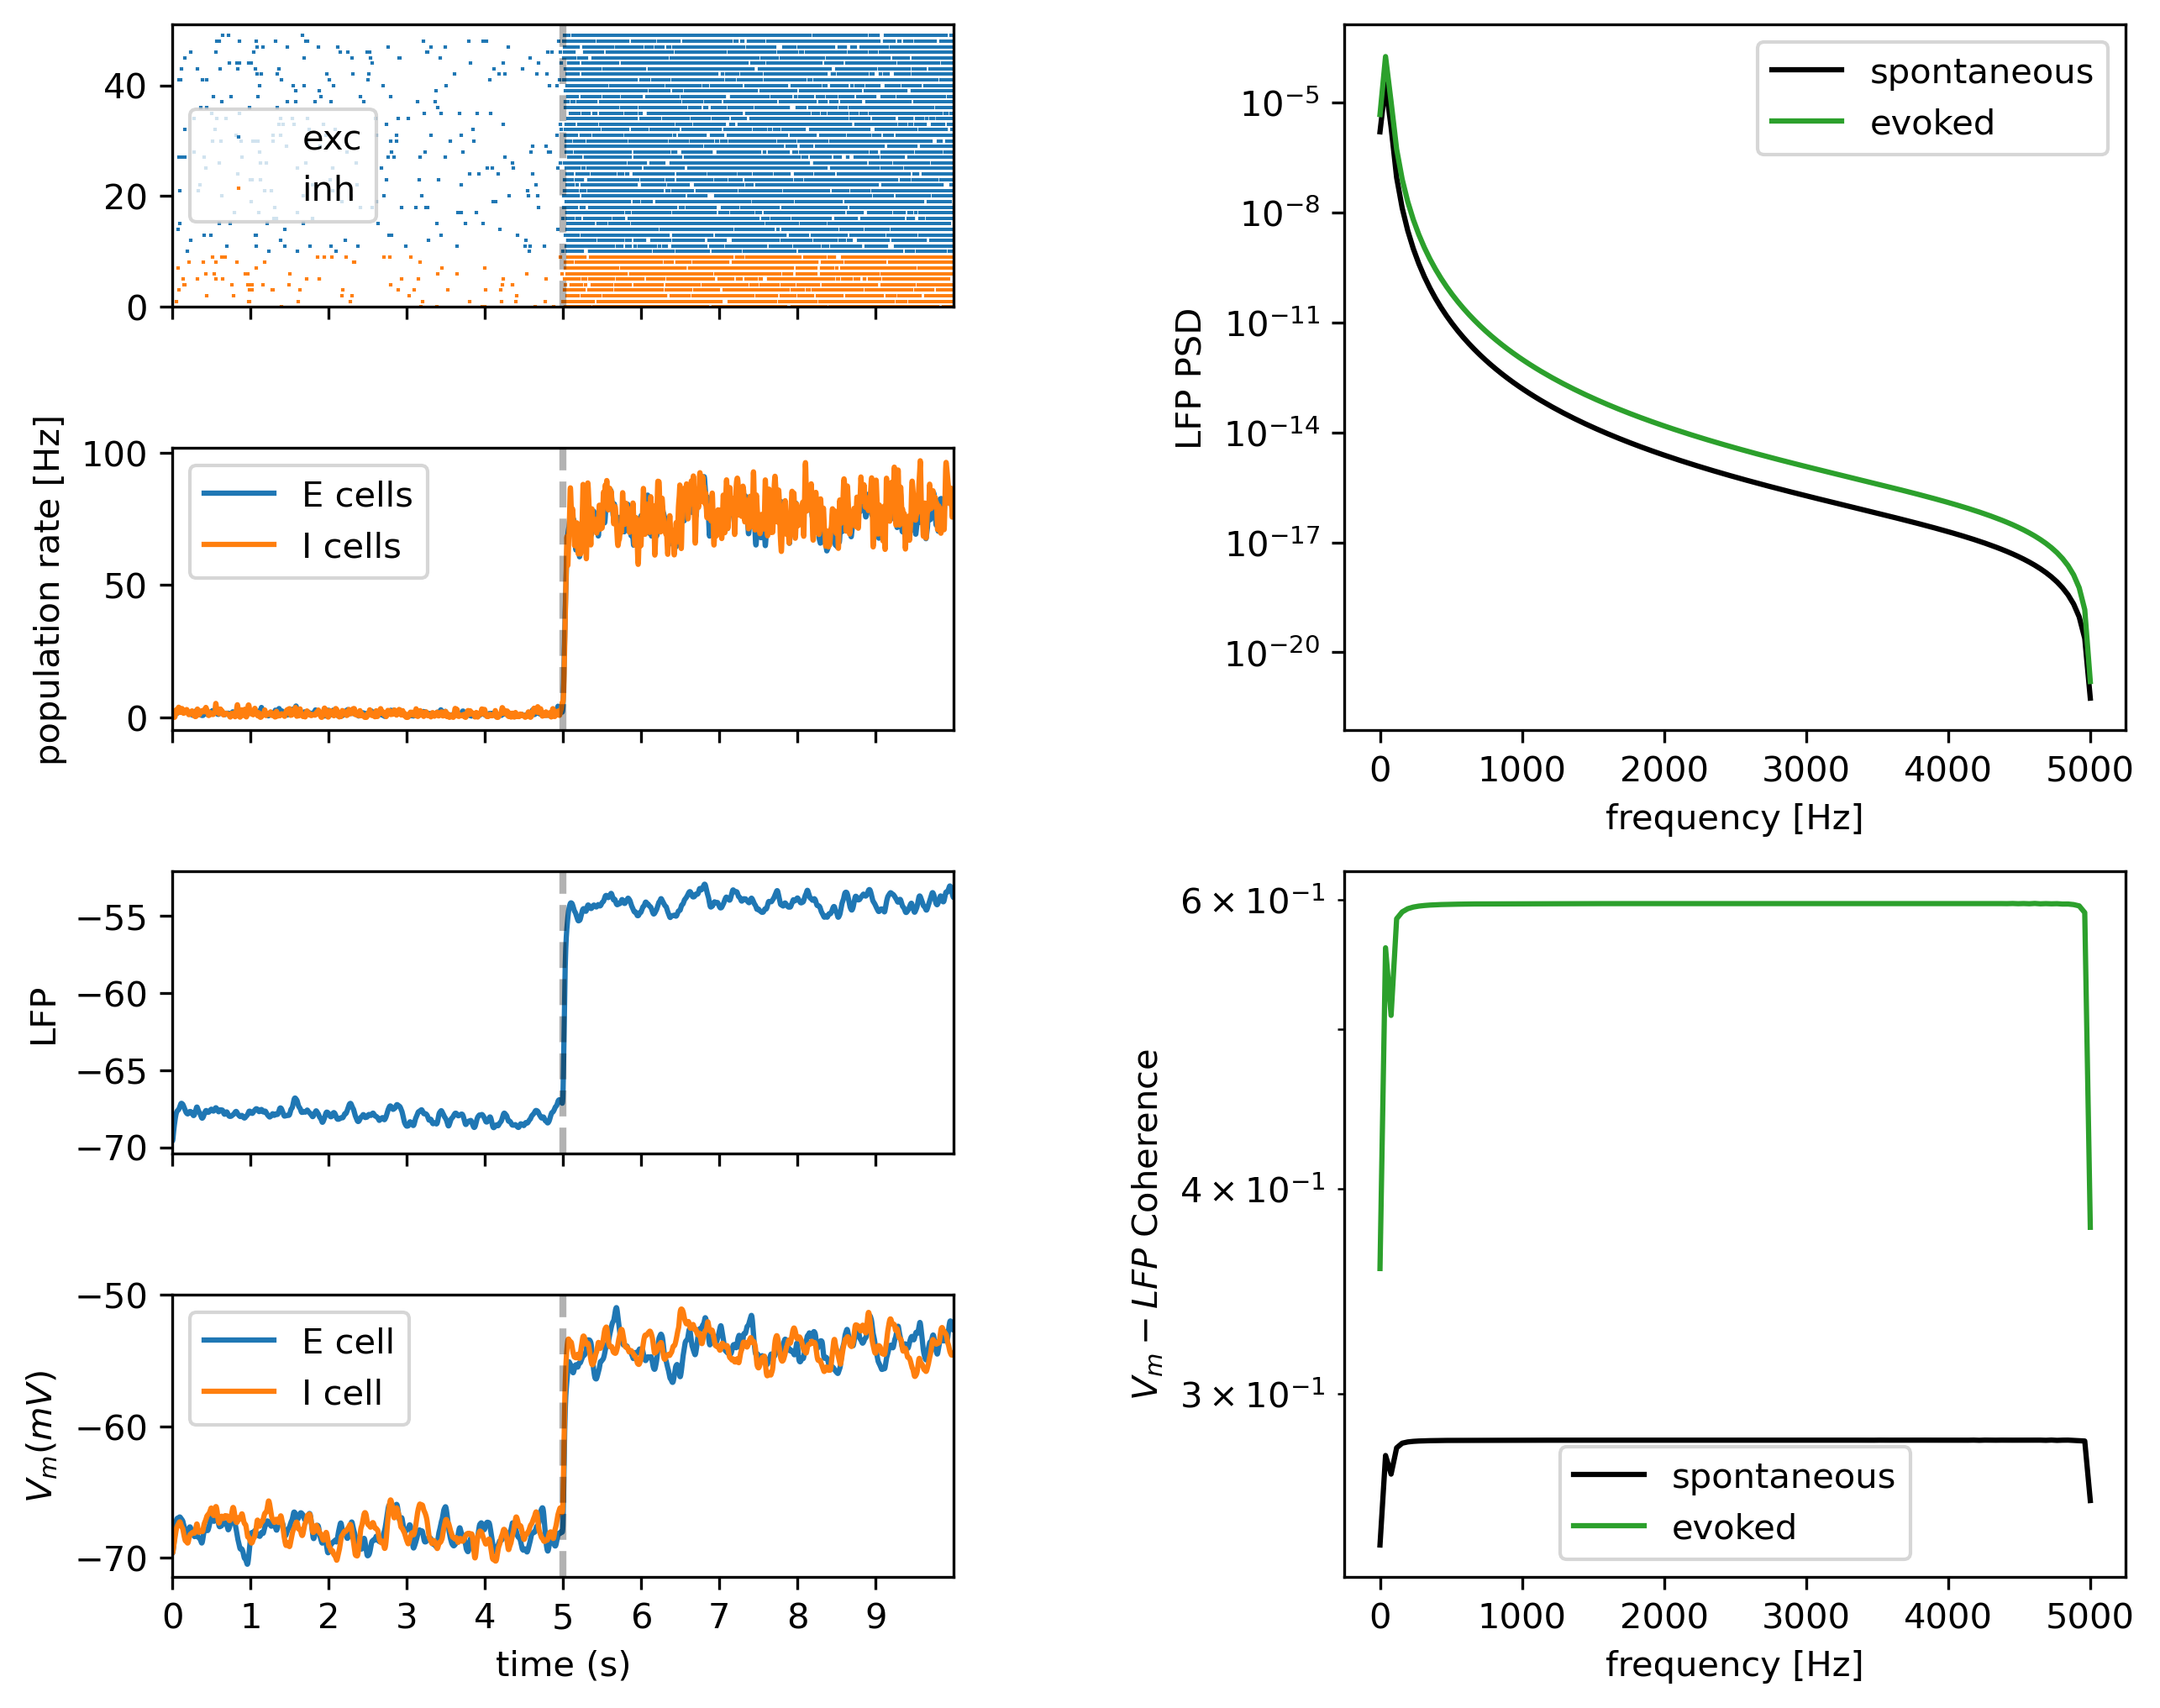

In [49]:
fig, axes = generate_figure3(E_spike_times=E_spike_times, I_spike_times=I_spike_times, v_t=v_t, gaussian_kernel_step_width=gaussian_kernel_step_width, N_E=N_E, N_I=N_I)
#generate_figure3(E_spike_times=E_spike_times,I_spike_times=I_spike_times,Gaussian_smoothed_EFR=Gaussian_smoothed_EFR,Gaussian_smoothed_IFR=Gaussian_smoothed_IFR,Gaussian_smoothed_LFP=Gaussian_smoothed_LFP,Gaussian_smoothed_V_E=Gaussian_smoothed_V_E,Gaussian_smoothed_V_I=Gaussian_smoothed_V_I)
plt.show()

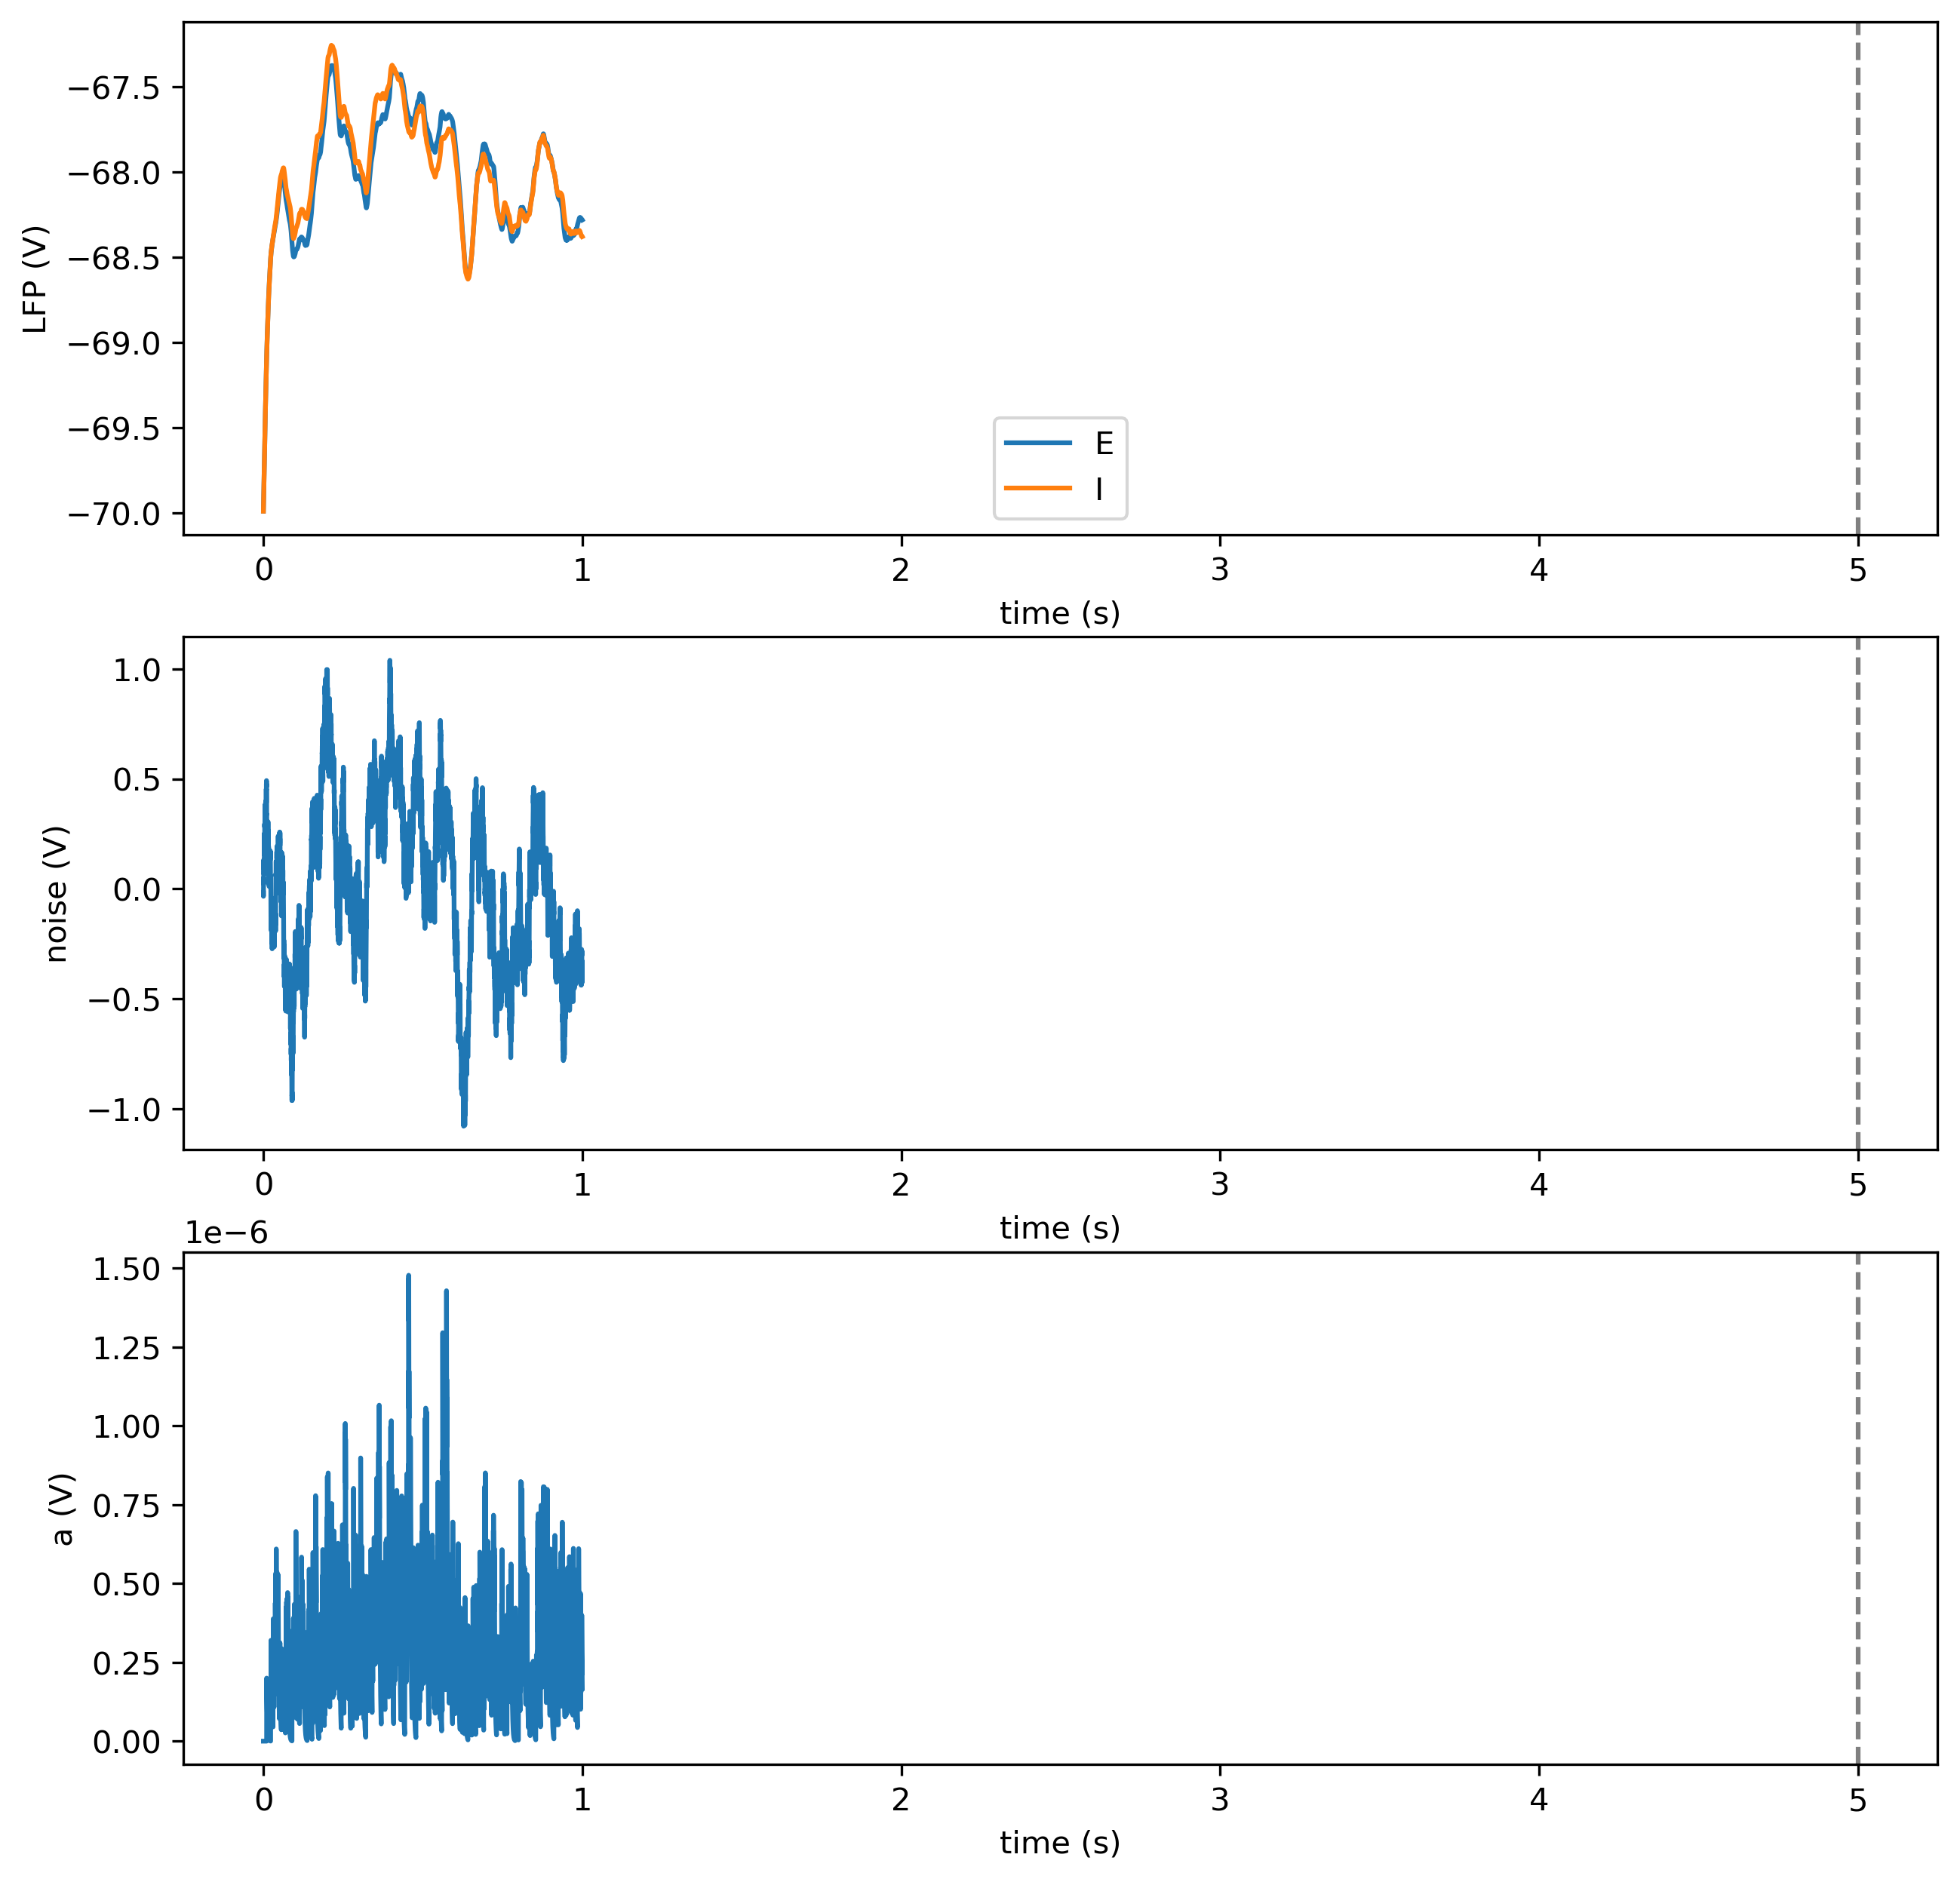

In [47]:
fig,ax=plt.subplots(3,1,figsize=(10,10))
ax[0].plot(np.linspace(0,tstop,num=int(tstop/dt)), np.mean(v_t[:,:N_E], axis=1), label='E')
ax[0].plot(np.linspace(0,tstop,num=int(tstop/dt)), np.mean(v_t[:,N_E:], axis=1), label='I')
ax[0].legend()      
ax[1].plot(np.linspace(0,tstop,num=int(tstop/dt)), np.mean(nu_t, axis=1))
ax[2].plot(np.linspace(0,tstop,num=int(tstop/dt)), np.mean(a_t, axis=1))
ax[0].set(xlabel='time (s)', ylabel='LFP (V)')
ax[1].set(xlabel='time (s)', ylabel='noise (V)')
ax[2].set(xlabel='time (s)', ylabel='a (V)')
ax[0].axvline(x=5, color='grey', ls='--')
ax[1].axvline(x=5, color='grey', ls='--')
ax[2].axvline(x=5, color='grey', ls='--')
plt.show()

In [ ]:
ax=axes[5]
f, Pxx_spontaneous=measure_PSD(lfp=Gaussian_smoothed_LFP[:int(5/dt)], dt=dt)
ax.semilogy(f, Pxx_spontaneous, label='spontaneous')
f, Pxx_evoked=measure_PSD(lfp=Gaussian_smoothed_LFP[int(5/dt):], dt=dt)
ax.semilogy(f, Pxx_evoked, label='evoked')
ax.legend()

In [56]:
def sim_OUprocess(N_E, N_I, tau_noise, tstop, dt, rho, sigma_noise, mu):

    Nt = int(tstop/dt)
    nu_t = np.empty(shape=(Nt,N_E+N_I))
    nu = np.zeros(N_E+N_I,)
    Sigma_noise=np.ones(shape=(N_E+N_I,N_E+N_I))*rho*sigma_noise**2+np.diag((1-rho)*np.ones([N_E+N_I])) #np.eye(N_E+N_I)
    #print(Sigma_noise)
    #print(np.sqrt(Sigma_noise))
    #sqrt_Sigma_noise=scipy.linalg.sqrtm(Sigma_noise)
    #sqrt_Sigma_noise=np.array(sqrt_Sigma_noise,dtype=float)
    
    for t in range(Nt):
        dW = np.random.randn(N_E+N_I) # generate N=N_E+N_I independent Wiener increments
        nu += dt*(-(nu-mu)/tau_noise) + np.sqrt(Sigma_noise).dot(dW)*np.sqrt(2/tau_noise)*np.sqrt(dt) # update O-U process
        nu_t[t]=nu
        
    return nu_t

N_E=1000
N_I=0
N=N_E+N_I
tstop=int(1/0.05)
dt=0.001
Nu_t=sim_OUprocess(N_E=N_E, N_I=0, tau_noise=1, tstop=tstop, dt=0.001, rho=0.2, sigma_noise=1, mu=0)

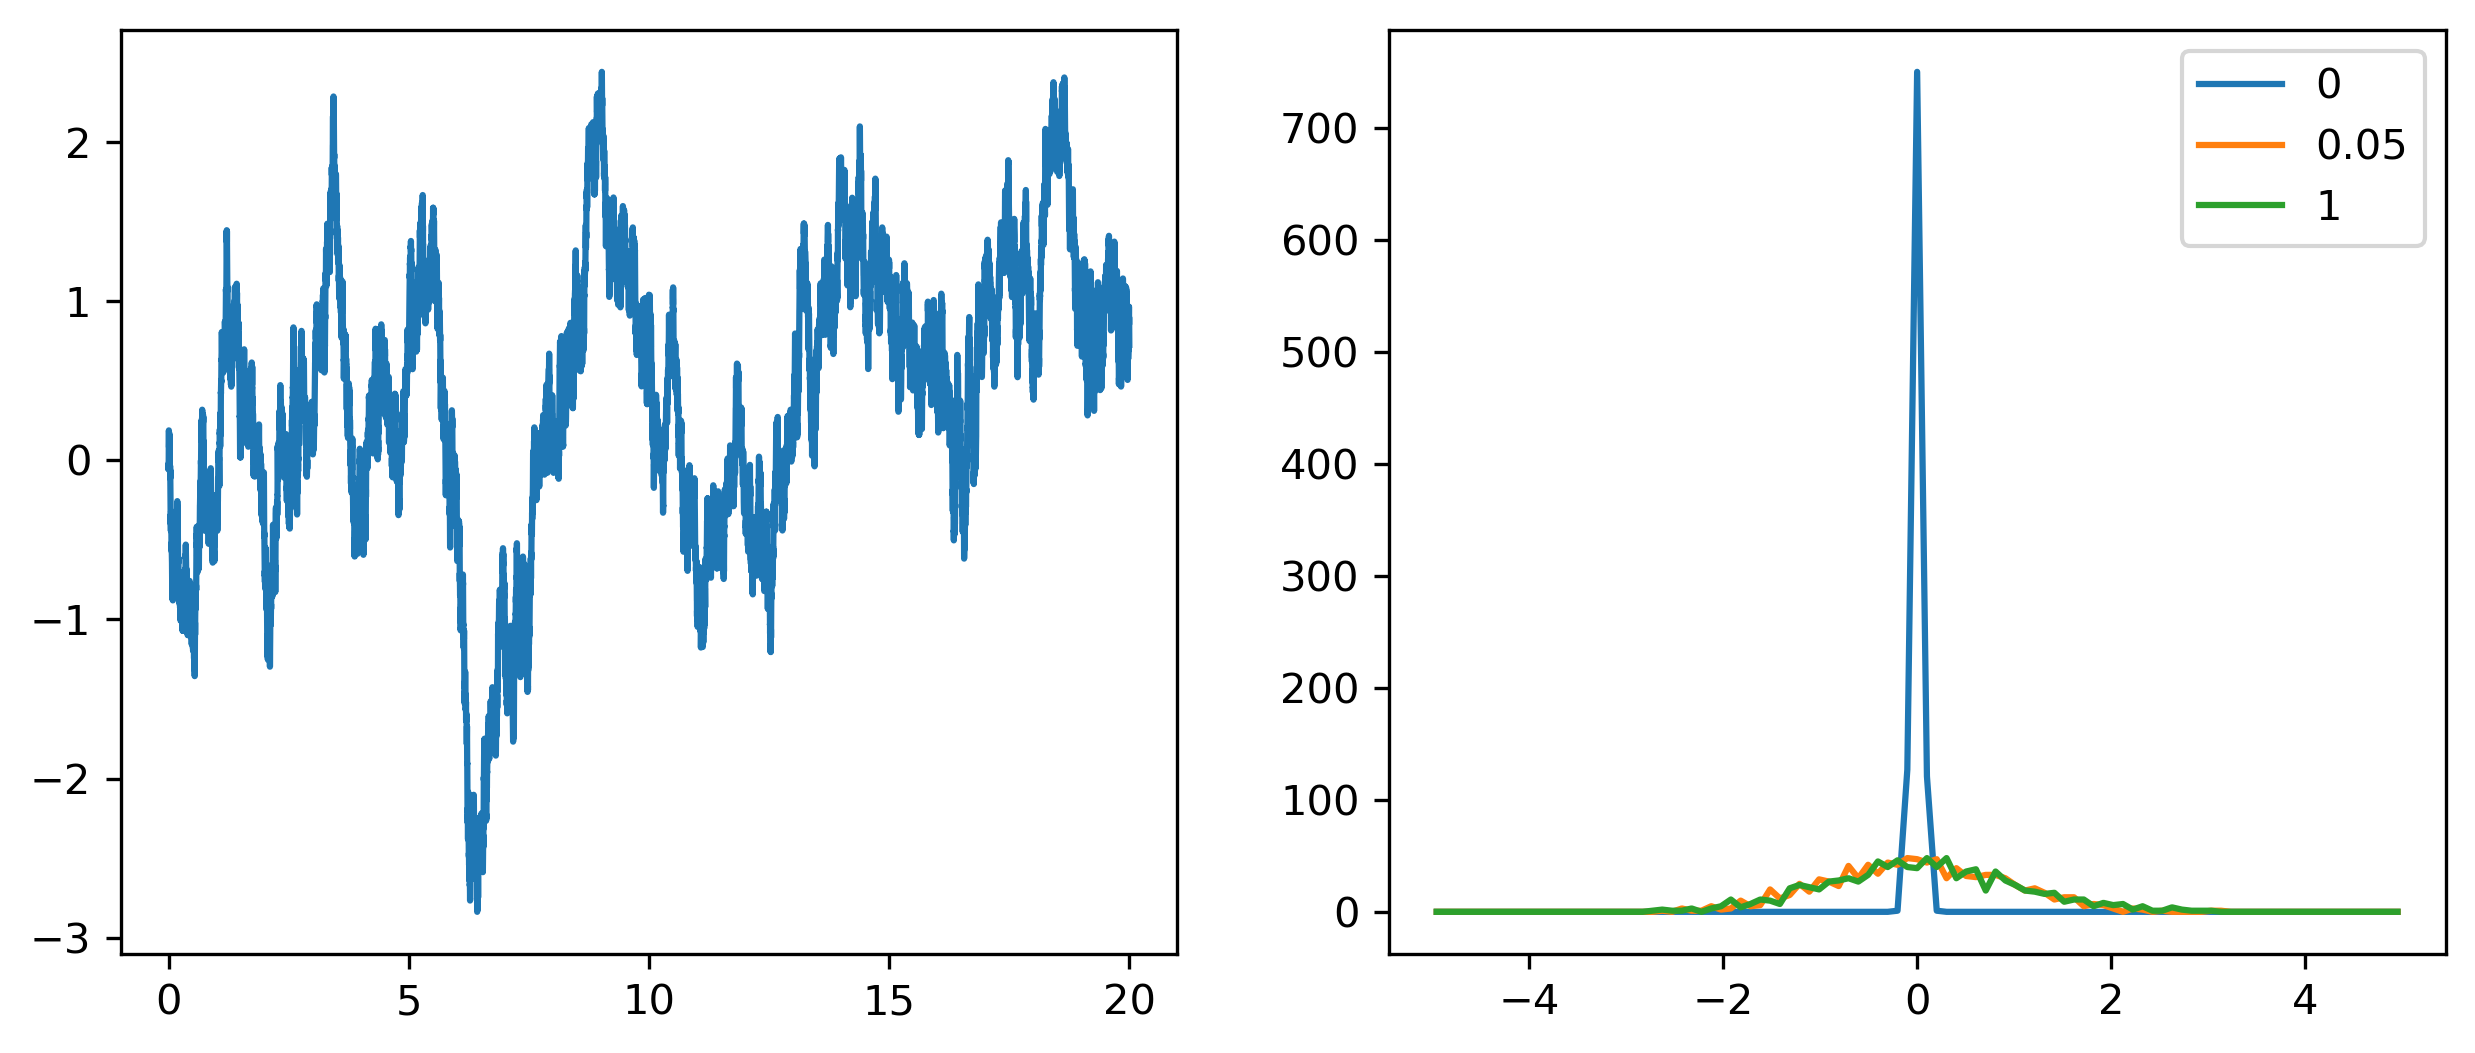

In [57]:
bins=np.linspace(-5,5,100)
fig,ax=plt.subplots(1,2, figsize=(10,3))
ax[0].plot(np.linspace(0,tstop,int(tstop/dt)),Nu_t[:,0])
ax[1].plot((bins[1:] + bins[:-1])/2, np.histogram(Nu_t[0],bins=bins)[0], label='0')
ax[1].plot((bins[1:] + bins[:-1])/2, np.histogram(Nu_t[int(0.05*tstop/dt)],bins=bins)[0], label='0.05')
ax[1].plot((bins[1:] + bins[:-1])/2, np.histogram(Nu_t[-1],bins=bins)[0], label='1')
ax[1].legend()

fig,ax=plt.subplots(1,1, figsize=(10,2))
for i in range(len(N)):
    
ax.plot()

plt.show()

In [12]:
def generate_figure3(E_spike_times,I_spike_times,Gaussian_smoothed_EFR,Gaussian_smoothed_IFR,Gaussian_smoothed_LFP,Gaussian_smoothed_V_E,Gaussian_smoothed_V_I):
    
    ncols,nrows=2,4
    fig = plt.figure(figsize=(7, 2*nrows))
    spec = gridspec.GridSpec(nrows, ncols, figure=fig) # grid on which to put plots
    ax_Vm = fig.add_subplot(spec[3,0]) # panel A: membrane potentials of one random E cell and one random I cell over time during simulation
    ax_raster = fig.add_subplot(spec[0,0], sharex = ax_Vm) # panel A: raster plot of spikes over time during simulation
    ax_FRs = fig.add_subplot(spec[1,0], sharex = ax_Vm) # panel A: population averaged firing rates over time during simulation
    ax_LFP = fig.add_subplot(spec[2,0], sharex = ax_Vm) # panel A: LFP over time during simulation
    ax_VmLFPcoherence = fig.add_subplot(spec[2:,1]) # panel B: LFP power (normalized) vs frequency, spontaneous and evoked
    ax_LFPpower = fig.add_subplot(spec[:2,1], sharex = ax_VmLFPcoherence) # panel B: LFP power (normalized) vs frequency, spontaneous and evoked
    time=np.linspace(0,tstop,num=int(tstop/dt))
    
    if Gaussian_smoothed_V_E is not None: ax_Vm.plot(time, Gaussian_smoothed_V_E, label='E cell')
    if Gaussian_smoothed_V_I is not None: ax_Vm.plot(time, Gaussian_smoothed_V_I, label='I cell')
    ax_Vm.axvline(x=5,ls='--',color='black',linewidth=2,alpha=0.3)
    ax_Vm.set(ylabel=r'$V_m (mV)$',xlabel='time (s)',xticks=np.arange(0,10,1),xticklabels=np.arange(0,10,1))
    ax_Vm.legend()
    
    if E_spike_times is not None: ax_raster.plot(E_spike_times[:,0],E_spike_times[:40,1],'|', markersize=1)
    if I_spike_times is not None: ax_raster.plot(I_spike_times[:,0],I_spike_times[:10,1],'|', markersize=1)
    ax_raster.axvline(x=5,ls='--',color='black',linewidth=2,alpha=0.3)
    plt.setp(ax_raster.get_xticklabels(), visible=False)
    
    if Gaussian_smoothed_EFR is not None: ax_FRs.plot(time, Gaussian_smoothed_EFR, label='E cells')
    if Gaussian_smoothed_IFR is not None: ax_FRs.plot(time, Gaussian_smoothed_IFR, label='I cells')
    ax_FRs.axvline(x=5,ls='--',color='black',linewidth=2,alpha=0.3)
    plt.setp(ax_FRs.get_xticklabels(), visible=False)
    ax_FRs.legend()
    
    if Gaussian_smoothed_LFP is not None: ax_LFP.plot(time, Gaussian_smoothed_LFP)
    ax_LFP.set(ylabel='LFP',xlabel=None)
    ax_LFP.axvline(x=5,ls='--',color='black',linewidth=2,alpha=0.3)
    plt.setp(ax_LFP.get_xticklabels(), visible=False)
    
    if Gaussian_smoothed_V_E is not None and Gaussian_smoothed_V_I is not None and Gaussian_smoothed_LFP is not None: 
        f, Cxy_spontaneous=measure_coherence(v_i=np.random.choice(a=[Gaussian_smoothed_V_E[:int(5/dt)],Gaussian_smoothed_V_I[:int(5/dt)]]), lfp=Gaussian_smoothed_LFP[:int(5/dt)], dt=dt)
        ax_VmLFPcoherence.semilogy(f, Cxy_spontaneous, label='spontaneous')
        f, Cxy_evoked=measure_coherence(v_i=np.random.choice(a=[Gaussian_smoothed_V_E[int(5/dt):],Gaussian_smoothed_V_I[int(5/dt):]]), lfp=Gaussian_smoothed_LFP[int(5/dt):], dt=dt)
        ax_VmLFPcoherence.semilogy(f, Cxy_evoked, label='evoked')
        ax_VmLFPcoherence.legend()
        f, Pxx_spontaneous=measure_PSD(lfp=Gaussian_smoothed_LFP[:int(5/dt)], dt=dt)
        ax_LFPpower.semilogy(f, Pxx_spontaneous, label='spontaneous')
        f, Pxx_evoked=measure_PSD(lfp=Gaussian_smoothed_LFP[int(5/dt):], dt=dt)
        ax_LFPpower.semilogy(f, Pxx_evoked, label='evoked')
        ax_LFPpower.legend()
        
    ax_VmLFPcoherence.set(xlabel='frequency [Hz]', ylabel=r'$V_m - LFP$'+'Coherence')
    ax_LFPpower.set(xlabel='frequency [Hz]', ylabel=r'LFP PSD')
    
    axes=[ax_raster, ax_FRs, ax_LFP, ax_Vm, ax_LFPpower, ax_VmLFPcoherence]
    
    return fig, axes

In [ ]:
# define and assign values to parameters; NOTE THAT CODE IS WRITTEN IN UNITS OF seconds (s) and volts (V) 
N_E=400 # number of excitatory neurons 
N_I=100 # number of excitatory neurons 
V_rest=-0.070 # resting membrane potential for all cells
V_0=-0.070 # initial (at start of simulation) membrane potential for all cells
tau_E=0.02 # membrane potential time constant for E cells, 20 ms
tau_I=0.02 # membrane potential time constant for I cells, 10 ms
tau_noise=0.05 # time constant for Ornstein-Uhlenbeck process (stochastic input to the network)
mu=0 # mean for Ornstein-Uhlenbeck process (stochastic input to the network)
sigma_noise=1 # square root of autocovariance of Ornstein-Uhlenbeck process
tau_syn=0.002 # synaptic time constant, 2 ms
h_spontaneous=0.002 # constant external input given to all cells prior to stimulus, 2 mV
h_stimulus=0.015 # constant external input given to all cells, constituting a stimulus, 15 mV
p_E=0.1 # probability that postsynaptic neuron i receives input from presynaptic E cell j
p_I=0.4 # probability that postsynaptic neuron i receives input from presynaptic I cell j
W_EE=1.35 # weight of presynaptic E cell input on MP of postsynaptic E cell
W_EI=-0.65 # weight of presynaptic E cell input on MP of postsynaptic I cell
W_IE=1.2 # weight of presynaptic I cell input on MP of postsynaptic E cell
W_II=-0.5 # weight of presynaptic I cell input on MP of postsynaptic I cell
k=0.3 # constant in equation 3; controls linear gain of the firing rate intensity function
alpha=2 # exponent in equ 3; controls nonlinearity of firing rate intensity function
delta=0.0005 # axonal time delay, 0.5 ms = 5 time steps
tstop=10 # length of time to run the simulation, 10 s
dt=0.0001 # size of time step to use in Euler-Maruyama method of SDE simulation
rho=0.2 # pairwise correlation coefficient
gaussian_kernel_time_width=0.05 # 50 ms = 500 time steps for time step dt size of 0.1 ms
gaussian_kernel_step_width=int(gaussian_kernel_time_width/dt) # 50 ms = 500 time steps for time step dt size of 0.1 ms